In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# get the accuracy metrics
from sklearn.metrics import r2_score
from mfbml.problems import MengCase1
from mfbml.methods.dnn_lr_bnn import DNNLinearRegressionBNN
from mfbml.methods.bayes_neural_nets import BNNWrapper
from mfbml.methods.dnn_bnn import DNNBNN

# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

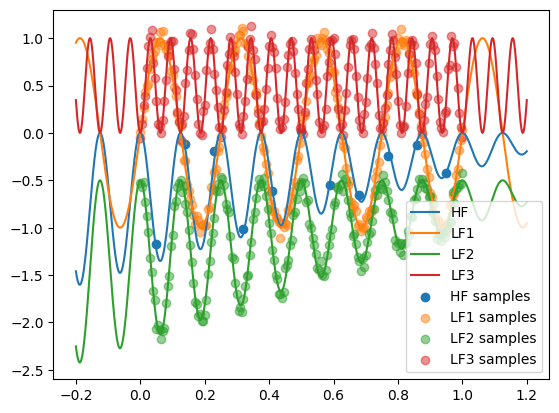

In [2]:
func = MengCase1(noise_std=0.0)
# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(0, 1, 201).reshape(-1, 1)
hf_samples = torch.linspace(0.05, 0.95, 11).reshape(-1, 1)
# add the end points

# training configure
samples = [hf_samples, lf_samples]

# generate responses
lf1_responses = func.lf1(lf_samples, noise_lf=0.05)
lf2_responses = func.lf2(lf_samples, noise_lf=0.05)
lf3_responses = func.lf3(lf_samples, noise_lf=0.05)
# get the high-fidelity responses
hf_responses = func.hf(hf_samples, noise_hf=0.05)
# generate the test points
test_samples = torch.linspace(-0.2, 1.2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf1_responses_noiseless = func.lf1(test_samples, noise_lf=0.0)
test_lf2_responses_noiseless = func.lf2(test_samples, noise_lf=0.0)
test_lf3_responses_noiseless = func.lf3(test_samples, noise_lf=0.0)
# noise responses
test_hf_responses = func.hf(test_samples, noise_hf=0.05)

# dataset of lf1 and hf
responses_lf1 = [hf_responses, lf1_responses]
# dataset of lf2 and hf
responses_lf2 = [hf_responses, lf2_responses]
# dataset of lf2 and hf
responses_lf3 = [hf_responses, lf3_responses]

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf1_responses_noiseless,   label="LF1")
ax.plot(test_samples, test_lf2_responses_noiseless,  label="LF2")
ax.plot(test_samples, test_lf3_responses_noiseless,  label="LF3")

# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf1_responses, alpha=0.5, label="LF1 samples")
ax.scatter(lf_samples, lf2_responses, alpha=0.5,  label="LF2 samples")
ax.scatter(lf_samples, lf3_responses, alpha=0.5, label="LF3 samples")

plt.legend()
# save the figure
# plt.savefig("sample_plan.png", dpi=300, bbox_inches="tight")
plt.show()

## Configurations for DNN and BNNs


In [3]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.000001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [500, 500],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [500, 500],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.001,
    "sigma": 0.05,
}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 100,
    "data_split": False,
}
hf_train_config = {
    "num_epochs": 2000,
    "sample_freq": 100,
    "print_info": True,
    "burn_in_epochs": 1000,
}

### train standard BNN using HF data


In [ ]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model
sigma_scale = float(0.05 / hf_responses_std)
bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[500, 500],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)
# train the model
bnn_model.train(
    X=hf_samples,
    Y=hf_responses_scaled,
    num_epochs=2000,
    sample_freq=100,
    burn_in_epochs=1000,
)

In [ ]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    X=test_samples)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
plt.figure()
plt.plot(hf_samples, hf_responses, "o", label="hf")
plt.plot(test_samples.numpy(), bnn_y, label="hf prediction")

plt.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
# plt.fill_between(
#     test_samples.flatten().numpy(),
#     (bnn_y - 2 * bnn_total_unc).reshape(-1),
#     (bnn_y + 2 * bnn_total_unc).reshape(-1),
#     alpha=0.5,
#     label="uncertainty",
# )
# plot the episitmic uncertainty
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_epistemic).reshape(-1),
    (bnn_y + 2 * bnn_epistemic).reshape(-1),
    alpha=0.5,
    label="epistemic uncertainty",
)
# plot aleatoric uncertainty
plt.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_aleatoric).reshape(-1),
    (bnn_y + 2 * bnn_aleatoric).reshape(-1),
    alpha=0.5,
    label="aleatoric uncertainty",
)
plt.legend()
plt.show()

# training of sequential MF-DNN-BNN model


In [ ]:
# sequential mf-bnn
smf_bnn_lf1 = DNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)

smf_bnn_lf1.train(
    X=samples,
    Y=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

In [ ]:
# visualize the posterior of sequential mf-bnn
(
    smf_bnn_lf1_hy,
    smf_bnn_lf1_epistemic,
    smf_bnn_lf1_total_unc,
    smf_bnn_lf1_aleatoric,
) = smf_bnn_lf1.predict(X=test_samples)
# get lf predictions
smf_bnn_lf1_y = smf_bnn_lf1.predict_lf(X=test_samples, output_format="numpy")
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), smf_bnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (smf_bnn_lf1_hy - 2 * smf_bnn_lf1_total_unc).reshape(-1),
    (smf_bnn_lf1_hy + 2 * smf_bnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)

# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(
    test_samples.numpy(),
    smf_bnn_lf1_y,
    label="LF prediction"
)
ax.legend()
plt.show()

In [4]:
# create the MFDNNBNN object
mfdnnbnn_lf1 = DNNLinearRegressionBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=True,
    lf_order=1,
    beta_bounds=[-5, 5],
    optimizer_restart=20,
    discrepancy_normalization="diff",
)

In [5]:
# define beta
mfdnnbnn_lf1.train(
    X=samples,
    Y=responses_lf1,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

No data split: use all data for training
epoch:  100 train loss:  0.9559196829795837
epoch:  200 train loss:  0.9555009603500366
epoch:  300 train loss:  0.9550385475158691
epoch:  400 train loss:  0.9544378519058228
epoch:  500 train loss:  0.9533059597015381
epoch:  600 train loss:  0.9461103677749634
epoch:  700 train loss:  0.87630695104599
epoch:  800 train loss:  0.7657046318054199
epoch:  900 train loss:  0.6124677062034607
epoch:  1000 train loss:  0.4524277150630951
epoch:  1100 train loss:  0.12163698673248291
epoch:  1200 train loss:  0.04886554181575775
epoch:  1300 train loss:  0.03381117433309555
epoch:  1400 train loss:  0.027652664110064507
epoch:  1500 train loss:  0.02525903843343258
epoch:  1600 train loss:  0.02372722327709198
epoch:  1700 train loss:  0.021466244012117386
epoch:  1800 train loss:  0.017293503507971764
epoch:  1900 train loss:  0.013124934397637844
epoch:  2000 train loss:  0.010485617443919182
epoch:  2100 train loss:  0.008861730806529522
epoch:  

/home/yaga/Documents/GitHub/mfbml/src/mfbml/inference/psgld.py:93: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1485.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:   100/ 2000
nll_loss: 204.125, prior_loss: 257030.484, total: 257234.609
noise: 0.140
epoch:   200/ 2000
nll_loss: 271.500, prior_loss: 269091.031, total: 269362.531
noise: 0.140
epoch:   300/ 2000
nll_loss: 148.243, prior_loss: 279337.938, total: 279486.188
noise: 0.140
epoch:   400/ 2000
nll_loss: 114.679, prior_loss: 288849.188, total: 288963.875
noise: 0.140
epoch:   500/ 2000
nll_loss: 85.624, prior_loss: 297620.406, total: 297706.031
noise: 0.140
epoch:   600/ 2000
nll_loss: 78.358, prior_loss: 305873.406, total: 305951.750
noise: 0.140
epoch:   700/ 2000
nll_loss: 146.869, prior_loss: 313211.281, total: 313358.156
noise: 0.140
epoch:   800/ 2000
nll_loss: 25.856, prior_loss: 320062.031, total: 320087.875
noise: 0.140
epoch:   900/ 2000
nll_loss: 13.989, prior_loss: 326234.125, total: 326248.125
noise: 0.140
epoch:  1000/ 2000
nll_loss: 25.280, prior_loss: 331965.844, total: 331991.125
noise: 0.140
epoch:  1100/ 2000
nll_loss: 40.464, prior_loss: 337177.344, total: 337217.

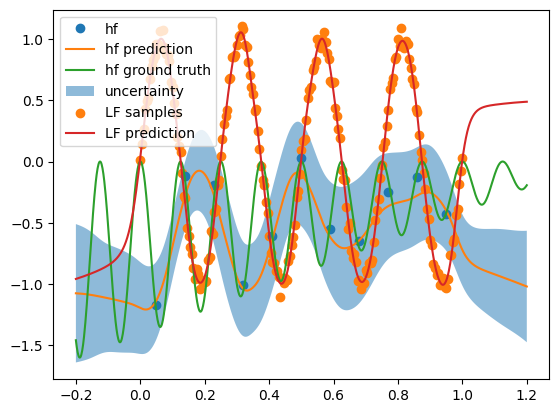

In [6]:
# visualize the posterior of mf-dnn-bnn
(
    mfdnnbnn_lf1_hy,
    mfdnnbnn_lf1_epistemic,
    mfdnnbnn_lf1_total_unc,
    mfdnnbnn_lf1_aleatoric,
) = mfdnnbnn_lf1.predict(X=test_samples)
# get lf predictions
mfdnnbnn_lf1_y = mfdnnbnn_lf1.predict_lf(X=test_samples, output_format="numpy")

# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_hy, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (mfdnnbnn_lf1_hy - 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    (mfdnnbnn_lf1_hy + 2 * mfdnnbnn_lf1_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf1_responses, label="LF samples")
ax.plot(test_samples.numpy(), mfdnnbnn_lf1_y,
        label="LF prediction")
ax.legend()
plt.show()